In [1]:
import numpy as np
from spectral_clustering import spectral_clustering
import functions_for_plotting
from asymmetric_laplacian_distribution import get_index_per_class, get_labels, labels_to_layout_mapping
from sklearn.cluster import KMeans
import training_set_split
import seaborn as sns
import prediction_strength
import importlib
import matplotlib.pyplot as plt
import seaborn as sns

/Users/paule/anaconda3/envs/bon17/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.nearest_centroid module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from spectral_clustering import calculate_dist_matrix
from spectral_clustering import construct_knn_graph
from spectral_clustering import get_local_scaled_affinity_matrix
from spectral_clustering import cluster_eigenvector_embedding
from spectral_clustering import calculate_eigenvectors_and_values
from spectral_clustering import calculate_normalized_laplacian
from sklearn.metrics import pairwise_distances

# Load Data and True Labels

In [3]:
#----------------------------------------------- DATA ------------------------------------------------------------------
data_dir = "data/"

clear_data = np.load(data_dir + "clearly_separated_data_F_signal_noise.npy")
ambig_data = np.load(data_dir + "ambiguous_data_tau_amplitude_F_signal_noise.npy")
#np.load(data_dir + "ambiguous_data_tau_amplitude_F_signal_noise.npy") #np.load(data_dir + "clearly_separated_data_F_signal_noise.npy")

clear_amplitude_conditions = ["S", "M", "L"]  #["S", "S/M", "M", "M/L", "L"] #["S", "M", "L"]
ambig_amplitude_conditions = ["S", "S/M", "M", "M/L", "L"]

clear_time_constant_conditions = ["equal_sharp", "equal_wide", "wide_sharp_negative_skew", "sharp_wide_positive_skew"]
ambig_time_constant_conditions = ["equal_sharp", "equal_medium", "equal_wide", "wide_sharp_negative_skew", "wide_medium_negative_skew","medium_sharp_negative_skew","sharp_wide_positive_skew", "medium_wide_positive_skew" ,"sharp_medium_positive_skew"]

#["equal_sharp", "equal_medium", "equal_wide", "wide_sharp_negative_skew", "wide_medium_negative_skew","medium_sharp_negative_skew","sharp_wide_positive_skew", "medium_wide_positive_skew" ,"sharp_medium_positive_skew"]
#["equal_sharp", "equal_wide", "wide_sharp_negative_skew", "sharp_wide_positive_skew"]

ambiguous_conditions = ["S/M", "M/L", "equal_medium", "wide_medium_negative_skew", "medium_sharp_negative_skew", "medium_wide_positive_skew", "sharp_medium_positive_skew"]

samples_per_condition = 1000
samples_per_ambiguous_condition = 400

ambig_cluster_dict = get_index_per_class(ambig_amplitude_conditions,ambig_time_constant_conditions, ambiguous_conditions, samples_per_condition, samples_per_ambiguous_condition)
clear_cluster_dict = get_index_per_class(clear_amplitude_conditions,clear_time_constant_conditions, [], samples_per_condition, samples_per_ambiguous_condition)


clear_true_labels = get_labels(clear_data, clear_cluster_dict)
ambig_true_labels = get_labels(ambig_data, ambig_cluster_dict)

clear_clusters_ordered = list(range(0,len(clear_cluster_dict)+1))
clear_layout_label_mapping = labels_to_layout_mapping(clear_clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 4, (1,4)) #labels_to_layout_mapping(clusters_ordered, 9, (2,5))

ambig_clusters_ordered = list(range(0,len(ambig_cluster_dict)+1))
ambig_layout_label_mapping = labels_to_layout_mapping(ambig_clusters_ordered, 9, (2,5))

## Cluster Balanced Split

In [4]:
clear_train_fold_indices, _ = training_set_split.get_training_folds(clear_data, clear_cluster_dict,cluster_split="balanced",folds = 2)
ambig_train_fold_indices, _ = training_set_split.get_training_folds(ambig_data, ambig_cluster_dict,cluster_split="balanced",folds = 2)


clear_training_set = clear_data[clear_train_fold_indices[0]]
clear_validation_set = clear_data[clear_train_fold_indices[1]]

ambig_training_set = ambig_data[ambig_train_fold_indices[0]]
ambig_validation_set = ambig_data[ambig_train_fold_indices[1]]

clear_true_labels_training = clear_true_labels[clear_train_fold_indices[0]]
clear_true_labels_validation = clear_true_labels[clear_train_fold_indices[1]]

ambig_true_labels_training = ambig_true_labels[ambig_train_fold_indices[0]]
ambig_true_labels_validation = ambig_true_labels[ambig_train_fold_indices[1]]

## Spectral Clustering Configuration

### Cluster Ambiguous Data

In [5]:
k = 10
regs = [None, 0.01, 0.1, 1, 10]  
ambig_prediction_strength_dir = "Toy_data/Ambiguous/Ambiguous_Tau_Amplitude/Prediction_Strength/"

In [44]:
def get_ssim_matrix(data):
    sim_matrix = data @ data.T 
    diag = sim_matrix.diagonal()
    denom = diag.reshape((len(diag),1)) + diag
    sim_matrix = 2 * sim_matrix / denom
    return sim_matrix

In [45]:
dist_matrix_train, sorted_dist_matrix_train = calculate_dist_matrix(ambig_training_set, "euclidean")
dist_matrix_valid, sorted_dist_matrix_valid = calculate_dist_matrix(ambig_validation_set, "euclidean")

In [46]:
sim_matrix_train = get_ssim_matrix(ambig_training_set)
sim_matrix_valid = get_ssim_matrix(ambig_validation_set)

In [47]:
matrix_train = (1-sim_matrix_train) * dist_matrix_train
matrix_valid = (1-sim_matrix_valid) * dist_matrix_valid

In [48]:
for reg in regs:
    labels_train, eigvec_train, eigval_train = spectral_clustering(ambig_training_set, "precomputed","distance",range(1,50),precomputed_matrix=matrix_train, k=k, mutual = False, weighting = False, normalize = True, reg_lambda = reg, save_laplacian = False, save_eigenvalues_and_vectors = False)
    np.save(ambig_prediction_strength_dir + "labels/labels_k=%d_reg=%s_SSIM_EUCLIDEAN_training" % (k, str(reg)),labels_train)
    np.save(ambig_prediction_strength_dir + "eigenvalues/eigval_k=%d_reg=%s_SSIM_EUCLIDEAN_training" % (k, str(reg)),eigval_train)
    
    labels_valid, eigvec_valid, eigval_valid = spectral_clustering(ambig_validation_set, "precomputed","distance", range(1,50),precomputed_matrix=matrix_valid,  k=k, mutual = False, weighting = False, normalize = True, reg_lambda = reg, save_laplacian = False, save_eigenvalues_and_vectors = False)
    np.save(ambig_prediction_strength_dir + "labels/labels_k=%d_reg=%s_SSIM_EUCLIDEAN_validation" % (k, str(reg)),labels_valid)
    np.save(ambig_prediction_strength_dir + "eigenvalues/eigval_k=%d_reg=%s_SSIM_EUCLIDEAN_validation" % (k, str(reg)),eigval_valid) 

Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Distance of data points!
Weighting: False
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Distance of data points!
Weighting: False
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Distance of data points!
Weighting: False
Calculate Normalized Laplacians
Apply regularization!
lamda = 0.0100
Calculate Eigenvalues and Vectors of Laplacian
Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Distance of data points!
Weighting: False
Calculate Normalized Laplacians
Apply regularization!
lamda = 0.0100
Calculate Eigenvalues and Vectors of Laplacian
Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Distance of data 

### Cluster Clear Data

In [31]:
k = 10
regs = [None, 0.01, 0.1, 1, 10, 100]  
clear_prediction_strength_dir = "Toy_data/Clearly_Separated/Prediction_Strength/"

In [32]:
for reg in regs:
    labels_train, eigvec_train, eigval_train = spectral_clustering(clear_training_set, "euclidean", "distance",range(1,50), k=k, mutual = False, weighting = False, normalize = True, reg_lambda = reg, save_laplacian = False, save_eigenvalues_and_vectors = False)
    np.save(clear_prediction_strength_dir + "labels/labels_k=%d_reg=%s_training" % (k, str(reg)),labels_train)
    np.save(clear_prediction_strength_dir + "eigenvalues/eigval_k=%d_reg=%s_training" % (k, str(reg)),eigval_train)
    
    labels_valid, eigvec_valid, eigval_valid = spectral_clustering(clear_validation_set, "euclidean","distance", range(1,50),  k=k, mutual = False, weighting = False, normalize = True, reg_lambda = reg, save_laplacian = False, save_eigenvalues_and_vectors = False)
    np.save(clear_prediction_strength_dir + "labels/labels_k=%d_reg=%s_validation" % (k, str(reg)),labels_valid)
    np.save(clear_prediction_strength_dir + "eigenvalues/eigval_k=%d_reg=%s_validation" % (k, str(reg)),eigval_valid)

Build symmetric KNN-Graph based on Distance of data points!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Build symmetric KNN-Graph based on Distance of data points!
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian
Build symmetric KNN-Graph based on Distance of data points!
Calculate Normalized Laplacians
Apply regularization!
lamda = 0.0100
Calculate Eigenvalues and Vectors of Laplacian
Build symmetric KNN-Graph based on Distance of data points!
Calculate Normalized Laplacians
Apply regularization!
lamda = 0.0100
Calculate Eigenvalues and Vectors of Laplacian
Build symmetric KNN-Graph based on Distance of data points!
Calculate Normalized Laplacians
Apply regularization!
lamda = 0.1000
Calculate Eigenvalues and Vectors of Laplacian
Build symmetric KNN-Graph based on Distance of data points!
Calculate Normalized Laplacians
Apply regularization!
lamda = 0.1000
Calculate Eigenvalues and Vectors of Laplacian
Build symmetric KN

# Distance and Similarity Metrics Analysis

## Subset of data to make computations easier

In [5]:
data = clear_data
cluster_dict = clear_cluster_dict

In [6]:
test_data = np.zeros((1200, len(data[0])))
test_cluster_dict = {}
for i,key in enumerate(list(cluster_dict.keys())):
    start = cluster_dict[key][0]
    test_data[i*100:(i+1)*100,:] = data[start:start+100,:]
    test_cluster_dict[key] = (i*100,(i+1)*100-1)

### Minkowski Distances 

In [38]:
dist_matrix_minkowski = pairwise_distances(data, data, metric = "minkowski", p = 0.5)

In [7]:
#np.save("minkowski_p=0.5_distances_ambig", dist_matrix)
dist_matrix_minkowski = np.load("distances/minkowski_p=0.5_distances_ambig.npy")

### Euclidean Distances 

In [8]:
dist_matrix_euclidean, _ = calculate_dist_matrix(data, "euclidean")

### Manhattan Distances

In [9]:
dist_matrix_manhattan, _ = calculate_dist_matrix(data, "manhattan")

### Dot Product

In [10]:
dist_matrix_dot = data@data.T

### Cosine Distance

In [11]:
dist_matrix_cos, _ = calculate_dist_matrix(data, "cosine")

### Mahalanobis distance

In [114]:
from scipy.spatial import distance
VI = np.linalg.inv(np.eye(test_data.shape[1]))

dist_matrix = distance.cdist(test_data[0:1], test_data, 'mahalanobis', VI = VI)

In [9]:
print(len(test_data))

1200


In [243]:
from scipy.spatial import distance

k_nn = np.zeros((len(test_data),10))
iterations = 3
VI = np.linalg.inv(np.eye(test_data.shape[1]))

for i in range(len(test_data)):
    VI_i = VI
    for iteration in range(iterations):
        X_i = test_data[i:(i+1)]
        distances_i = distance.cdist(X_i, test_data, 'mahalanobis', VI = VI)
        k_nearest = test_data[np.argsort(distances_i[0])[1:11]] #self not included
        VI_i = np.linalg.pinv(np.cov(k_nearest.T))
    
    if i % 10 == 0:
        print("Done for point: %d" % (i))
    
    k_nn[i] = np.argsort(distances_i[0])[1:11]

Done for point: 0
Done for point: 10
Done for point: 20
Done for point: 30
Done for point: 40


KeyboardInterrupt: 

In [241]:
k_nn[130]

array([196., 103., 177., 102., 166., 141., 126., 133., 110., 198.])

In [ ]:
np.save("k_nn_mahalanobis", k_nn)

### Wasserstein distance

In [41]:
from scipy.stats import wasserstein_distance
from scipy.stats import spearmanr

dist_matrix = np.zeros((len(test_data), len(test_data)))
for i in range(len(test_data)):
    for j in range(len(test_data)):
        if i == j:
            continue  # self-distance is 0.0
        if i > j:
            dist_matrix[i, j] = dist_matrix[j, i]  # re-use earlier calc
        dist_matrix[i, j] = wasserstein_distance(test_data[i], test_data[j])

In [13]:
#np.save("wasserstein_distances", dist_matrix)
dist_matrix_wasserstein = np.load("wasserstein_distances.npy")

### local scaled affinity matrix  

In [12]:
dist_matrix_local_scaled, _ = get_local_scaled_affinity_matrix(data,k=100,metric="euclidean")

### Similarity matrix based on constrast structure paper

In [14]:
#2xy/(x2+y2)

#dist_matrix = np.ones((len(clear_data), len(clear_data)))
#for i in range(len(clear_data)):
#    for j in range(len(clear_data)):
#        if i == j:
#            continue  # self-distance is 1
#        if i > j:
#            dist_matrix[i, j] = dist_matrix[j, i]  # re-use earlier calc
#             
#        dist_matrix[i, j] = 2 * (clear_data[i] @ clear_data[j].T) / (clear_data[i] @ clear_data[i].T + clear_data[j] @ clear_data[j].T)


sim_matrix = data @ data.T 
diag = sim_matrix.diagonal()
denom = diag.reshape((len(diag),1)) + diag
sim_matrix = 2 * sim_matrix / denom

#sim_matrix = np.load("SSIM.npy")

In [15]:
dist_matrix_SSIM = 1 - sim_matrix

### Similarity weighted  euclidean Distances 

In [150]:
weighted_dist_matrix = (1 - sim_matrix) * dist_matrix

In [53]:
print(np.argsort(weighted_dist_matrix)[:,0:10])
print(np.argsort(dist_matrix)[:,0:10])
print(np.argsort(sim_matrix)[:,-10:])

[[    0   340   170 ...   154   420   328]
 [    1   450   672 ...   361   807   719]
 [    2   464   229 ...   196   537   504]
 ...
 [11997 11179 11922 ... 11660 11108 11348]
 [11998 11811 11724 ... 11367 11578 11444]
 [11999 11316 11148 ... 11686 11445 11614]]
[[    0   340   170 ...   154   328   420]
 [    1   450   672 ...   361   807   284]
 [    2   464   229 ...   712   537   504]
 ...
 [11997 11179 11922 ... 11660 11108 11559]
 [11998 11811 11724 ... 11367 11578 11444]
 [11999 11316 11148 ... 11686 11614 11684]]
[[   84   420   154 ...   170   340     0]
 [  719   807   361 ...   672   450     1]
 [  141   537   196 ...   229   464     2]
 ...
 [11295 11108 11660 ... 11922 11179 11997]
 [11444 11578 11367 ... 11724 11811 11998]
 [11614 11445 11686 ... 11148 11316 11999]]


## Plot Between and within cluster distances 

In [214]:
data = clear_data
cluster_dict = clear_cluster_dict 
matrix = (1-dist_matrix_local_scaled)
matrix_info = "Distance"

In [70]:
test_cluster_dict

{'S-equal_sharp': (0, 99),
 'S-equal_wide': (100, 199),
 'S-wide_sharp_negative_skew': (200, 299),
 'S-sharp_wide_positive_skew': (300, 399),
 'M-equal_sharp': (400, 499),
 'M-equal_wide': (500, 599),
 'M-wide_sharp_negative_skew': (600, 699),
 'M-sharp_wide_positive_skew': (700, 799),
 'L-equal_sharp': (800, 899),
 'L-equal_wide': (900, 999),
 'L-wide_sharp_negative_skew': (1000, 1099),
 'L-sharp_wide_positive_skew': (1100, 1199)}

In [215]:
savefile = "(1-euclidean_local_scaled_k=100)_within_between"

In [216]:
within_cluster_distances = {}
between_cluster_distances = {}
for i,key in enumerate(list(cluster_dict.keys())):
    start,end = cluster_dict[key]
    within_cluster_distances[i] = matrix[start:end+1, start:end+1]
    between_cluster_distances[i] = np.delete(matrix[start:end+1], range(start,end+1), axis = 1)

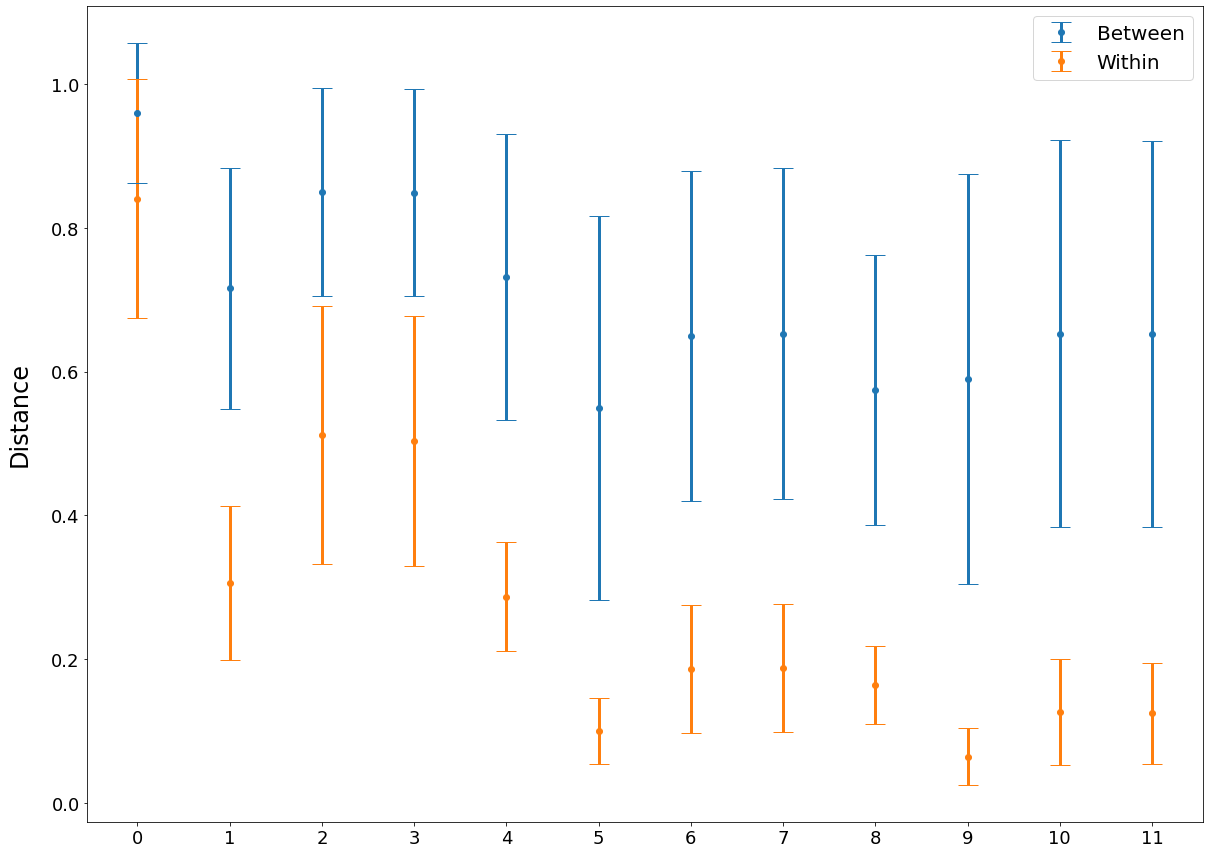

In [217]:
fig, ax = plt.subplots(figsize = (20,15))

w_means = [np.mean(within_cluster_distances[key]) for key in within_cluster_distances.keys()]
w_stds = [np.std(within_cluster_distances[key]) for key in within_cluster_distances.keys()]

b_means = [np.mean(between_cluster_distances[key]) for key in between_cluster_distances.keys()]
b_stds = [np.std(between_cluster_distances[key]) for key in between_cluster_distances.keys()]


ax.errorbar(list(between_cluster_distances.keys()), b_means, b_stds, lw=3, label = "Between",fmt='o', capsize=10)
ax.errorbar(list(within_cluster_distances.keys()), w_means, w_stds, lw=3, label = "Within",fmt='o', capsize=10)
ax.legend(fontsize= 20)

ax.tick_params(axis='y',labelsize=18)
ax.tick_params(axis="x", labelsize = 18)
ax.set_ylabel(matrix_info, fontsize = 24,labelpad = 20)
ax.set_xticks(range(0, len(list(between_cluster_distances.keys()))))
plt.savefig(savefile)

# Plot Median inter/ intra distance as function of metric

In [16]:
matrix_list = [dist_matrix_minkowski, dist_matrix_euclidean,dist_matrix_manhattan, dist_matrix_dot, dist_matrix_cos, dist_matrix_SSIM, (1-dist_matrix_local_scaled), (dist_matrix_SSIM * dist_matrix_euclidean)]

In [17]:
data = clear_data
cluster_dict = clear_cluster_dict 
matrix_info = "Distance (normalized by max distance)"

within_medians = []
between_medians = []
max_values = []

for matrix in matrix_list:
    within_cluster_distances = []
    between_cluster_distances = []
    for i,key in enumerate(list(cluster_dict.keys())):
        start,end = cluster_dict[key]
        within_cluster_distances.append(matrix[start:end+1, start:end+1])
        between_cluster_distances.append(np.delete(matrix[start:end+1], range(start,end+1), axis = 1))
    within_medians.append(np.median(within_cluster_distances))
    between_medians.append(np.median(between_cluster_distances))
    max_values.append(np.amax(matrix))

In [18]:
scaled_within_medians = [within_medians[i]/np.round(max_value) for i, max_value in enumerate(max_values)]
scaled_between_medians = [between_medians[i]/np.round(max_value) for i, max_value in enumerate(max_values)]

In [21]:
differences_within_between = np.asarray(scaled_between_medians) - np.asarray(scaled_within_medians)
print(differences_within_between)
smallest_to_largest_distance = np.argsort(differences_within_between)

[ 0.11587269  0.24998799  0.18276945 -0.0200051   0.62467845  0.77651603
  0.54961942  0.2092898 ]


In [165]:
save_file = "comparison_of_median_distance_for_metrics2"

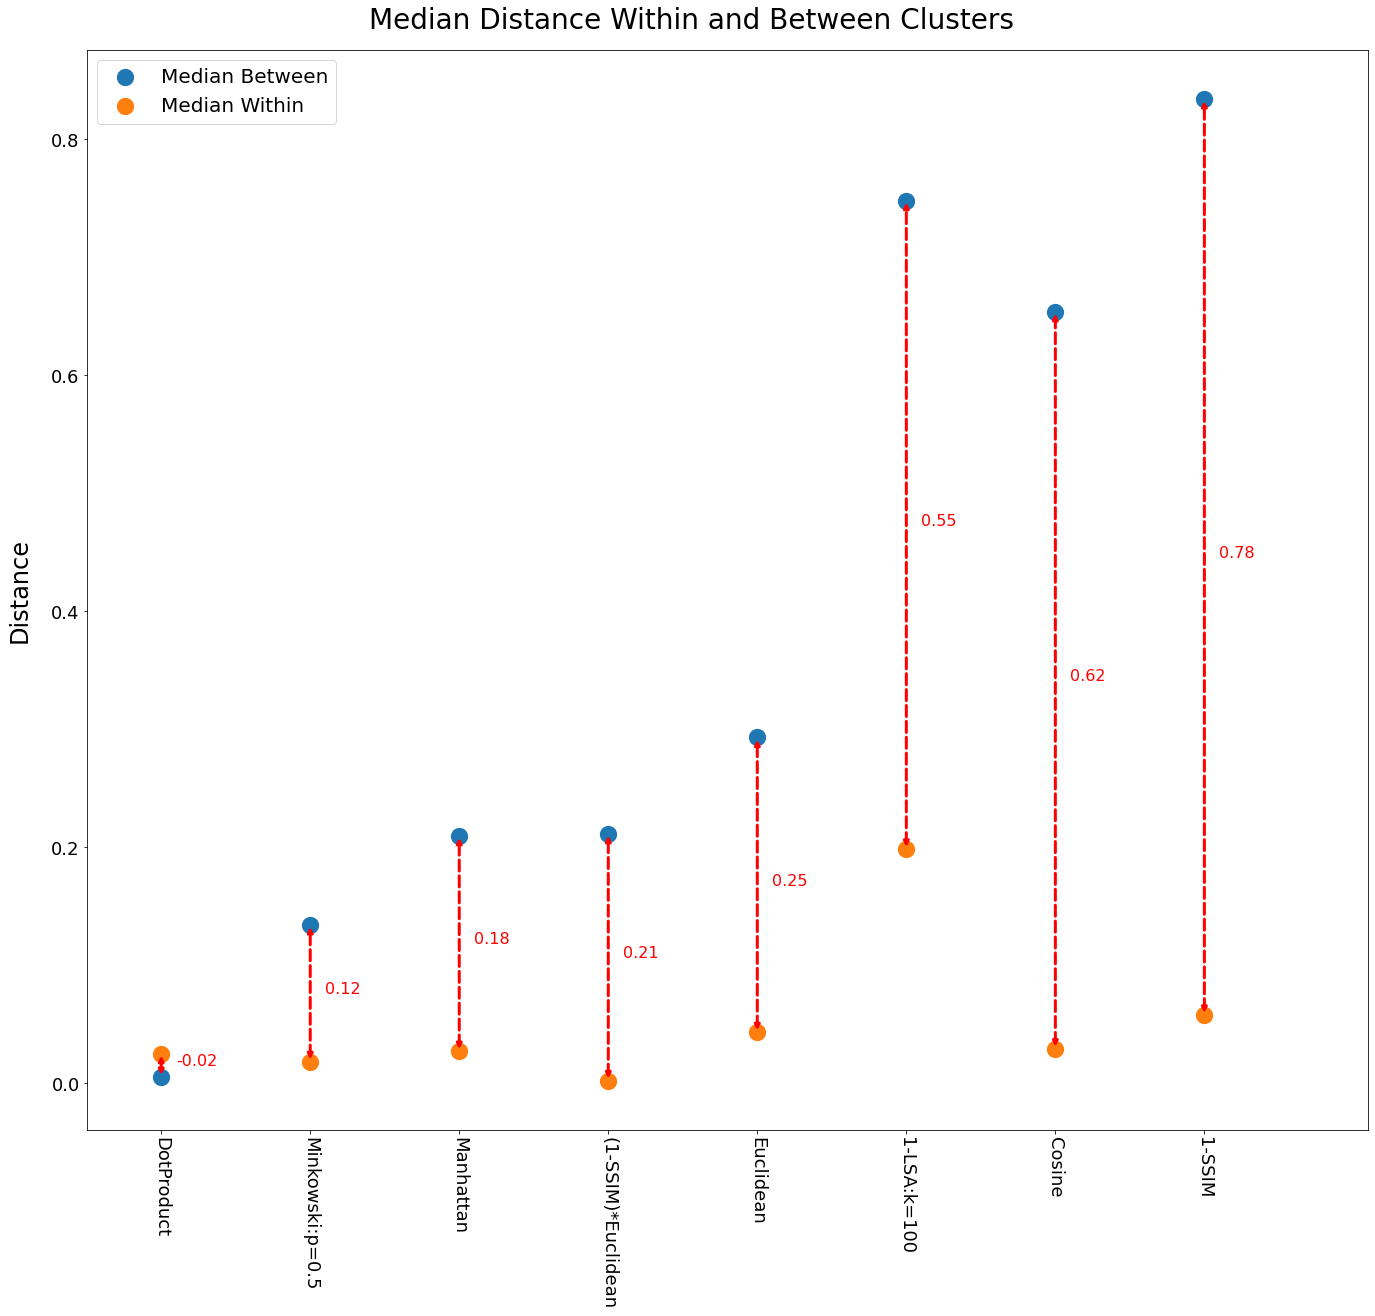

In [177]:
fig, ax = plt.subplots(figsize = (20,20))
plt.subplots_adjust(left=0.08,right=0.97,bottom=0.2,top=0.95)

distances = ["Minkowski:p=0.5", "Euclidean", "Manhattan", "DotProduct", "Cosine", "1-SSIM", "1-LSA:k=100", "(1-SSIM)*Euclidean"]
distances_sorted = np.asarray(distances)[smallest_to_largest_distance]
scaled_between_medians_sorted = np.asarray(scaled_between_medians)[smallest_to_largest_distance]
scaled_within_medians_sorted = np.asarray(scaled_within_medians)[smallest_to_largest_distance]

ax.scatter(distances_sorted,scaled_between_medians_sorted, lw=5, label = "Median Between", marker='o',s= 150)
ax.scatter(distances_sorted,scaled_within_medians_sorted, lw=5, label = "Median Within",marker='o', s= 150)


#differ_lines = []
medians = zip(scaled_within_medians_sorted, scaled_between_medians_sorted)

for i, j in zip(range(len(distances)),medians):
    pair = [(i, j[0]), (i, j[1])]
    #differ_lines.append(pair)
    ax.annotate(s='', xy=(i,j[1]), xytext=(i,j[0]), arrowprops=dict(arrowstyle='<|-|>',lw= 3,ls="dashed", color="red"))
    ax.annotate('%.2f' % (j[1]-j[0]), (i + 0.1,j[0] + (j[1]-j[0])*0.5), fontsize=16, color="red")    
#linecoll = matcoll.LineCollection(differ_lines, colors='k', linestyles = 'dashed')
#ax.add_collection(linecoll)


ax.legend(fontsize= 20)

ax.tick_params(axis='y',labelsize=18)
ax.tick_params(axis="x", labelsize = 18,rotation = -90)
ax.set_ylabel(matrix_info, fontsize = 24,labelpad = 20)
ax.set_xticks(range(0, len(distances)))
ax.set_xlim((-0.5, len(distances)+0.1))
fig.suptitle("Median Distance Within and Between Clusters", fontsize=28)
plt.savefig(save_file)

# Distance within and between individual clusters

### get distances within and between for each metric and cluster 

In [26]:
from itertools import product

In [132]:
matrix_list = [dist_matrix_minkowski, dist_matrix_euclidean,dist_matrix_manhattan, dist_matrix_dot, dist_matrix_cos, dist_matrix_SSIM, (1-dist_matrix_local_scaled), (dist_matrix_SSIM * dist_matrix_euclidean)]
metric_keys = ["Minkowski:p=0.5", "Euclidean", "Manhattan", "DotProduct", "Cosine", "1-SSIM", "1-LSA:k=100", "(1-SSIM)*Euclidean"]

In [133]:
data = clear_data
cluster_dict = clear_cluster_dict 
matrix_info = "Distance"

In [134]:
keys = list(cluster_dict.keys())
metric_keys = ["Minkowski:p=0.5", "Euclidean", "Manhattan", "DotProduct", "Cosine", "1-SSIM", "1-LSA:k=100", "(1-SSIM)*Euclidean"]
clusters = range(len(keys))

within_distances = {}
between_distances = {}
within_distances_means_stds = {}
between_distances_means_stds = {}

max_values = []

for m,matrix in enumerate(matrix_list):
    within_cluster_distances = {}
    within_cluster_distances_means_stds = {}
    
    between_cluster_distances = {}
    between_cluster_distances_means_stds = {}
    for c in clusters:
        between_cluster_distances[c] = {}
        between_cluster_distances_means_stds[c] = {}
        
    for i,j in list(product(clusters, repeat=2)):
        start_i,end_i = cluster_dict[keys[i]]
        start_j,end_j = cluster_dict[keys[j]]
        
        if i==j:
            within_cluster_distances[i] = matrix[start_i:end_i+1, start_i:end_i+1]
            mean = np.mean(matrix[start_i:end_i+1, start_i:end_i+1])
            std  = np.std(matrix[start_i:end_i+1, start_i:end_i+1])
            median = np.median(matrix[start_i:end_i+1, start_i:end_i+1])
            within_cluster_distances_means_stds[i] = (mean,median,std) 
        else:
            between_cluster_distances[i][j] = matrix[start_i:end_i+1, start_j:end_j+1]
            mean = np.mean(matrix[start_i:end_i+1, start_j:end_j+1])
            std  = np.std(matrix[start_i:end_i+1, start_j:end_j+1])
            median = np.median(matrix[start_i:end_i+1, start_j:end_j+1])
            
            between_cluster_distances_means_stds[i][j] = (mean,median,std)
    
    metric_key = metric_keys[m]
    within_distances[metric_key] = within_cluster_distances
    between_distances[metric_key] = between_cluster_distances
    within_distances_means_stds[metric_key] = within_cluster_distances_means_stds
    between_distances_means_stds[metric_key] = between_cluster_distances_means_stds
    
    max_values.append(np.amax(matrix))

###  plot boxplot for distances within and between each cluster 

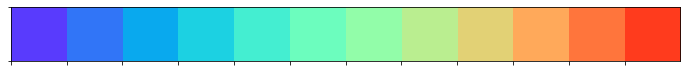

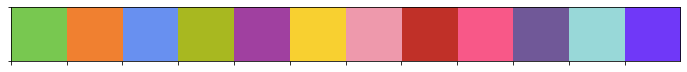

In [66]:
sns.palplot(sns.color_palette("rainbow",12))
colors = sns.color_palette('rainbow',12)
pkmn_type_colors = ['#78C850',  # Grass
                    '#F08030',  # Fire
                    '#6890F0',  # Water
                    '#A8B820',  # Bug
                    '#A040A0',  # Poison
                    '#F8D030',  # Electric
                    '#EE99AC',  # Fairy
                    '#C03028',  # Fighting
                    '#F85888',  # Psychic
                    '#705898',  # Ghost
                    '#98D8D8',  # Ice
                    '#7038F8',  # Dragon
                   ]
sns.palplot(sns.color_palette(pkmn_type_colors))
colors = sns.color_palette(pkmn_type_colors)

In [194]:
np.round(max_values)

array([7.3955778e+07, 4.2600000e+02, 2.2530000e+04, 1.7864000e+05,
       1.0000000e+00, 1.0000000e+00, 1.0000000e+00])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


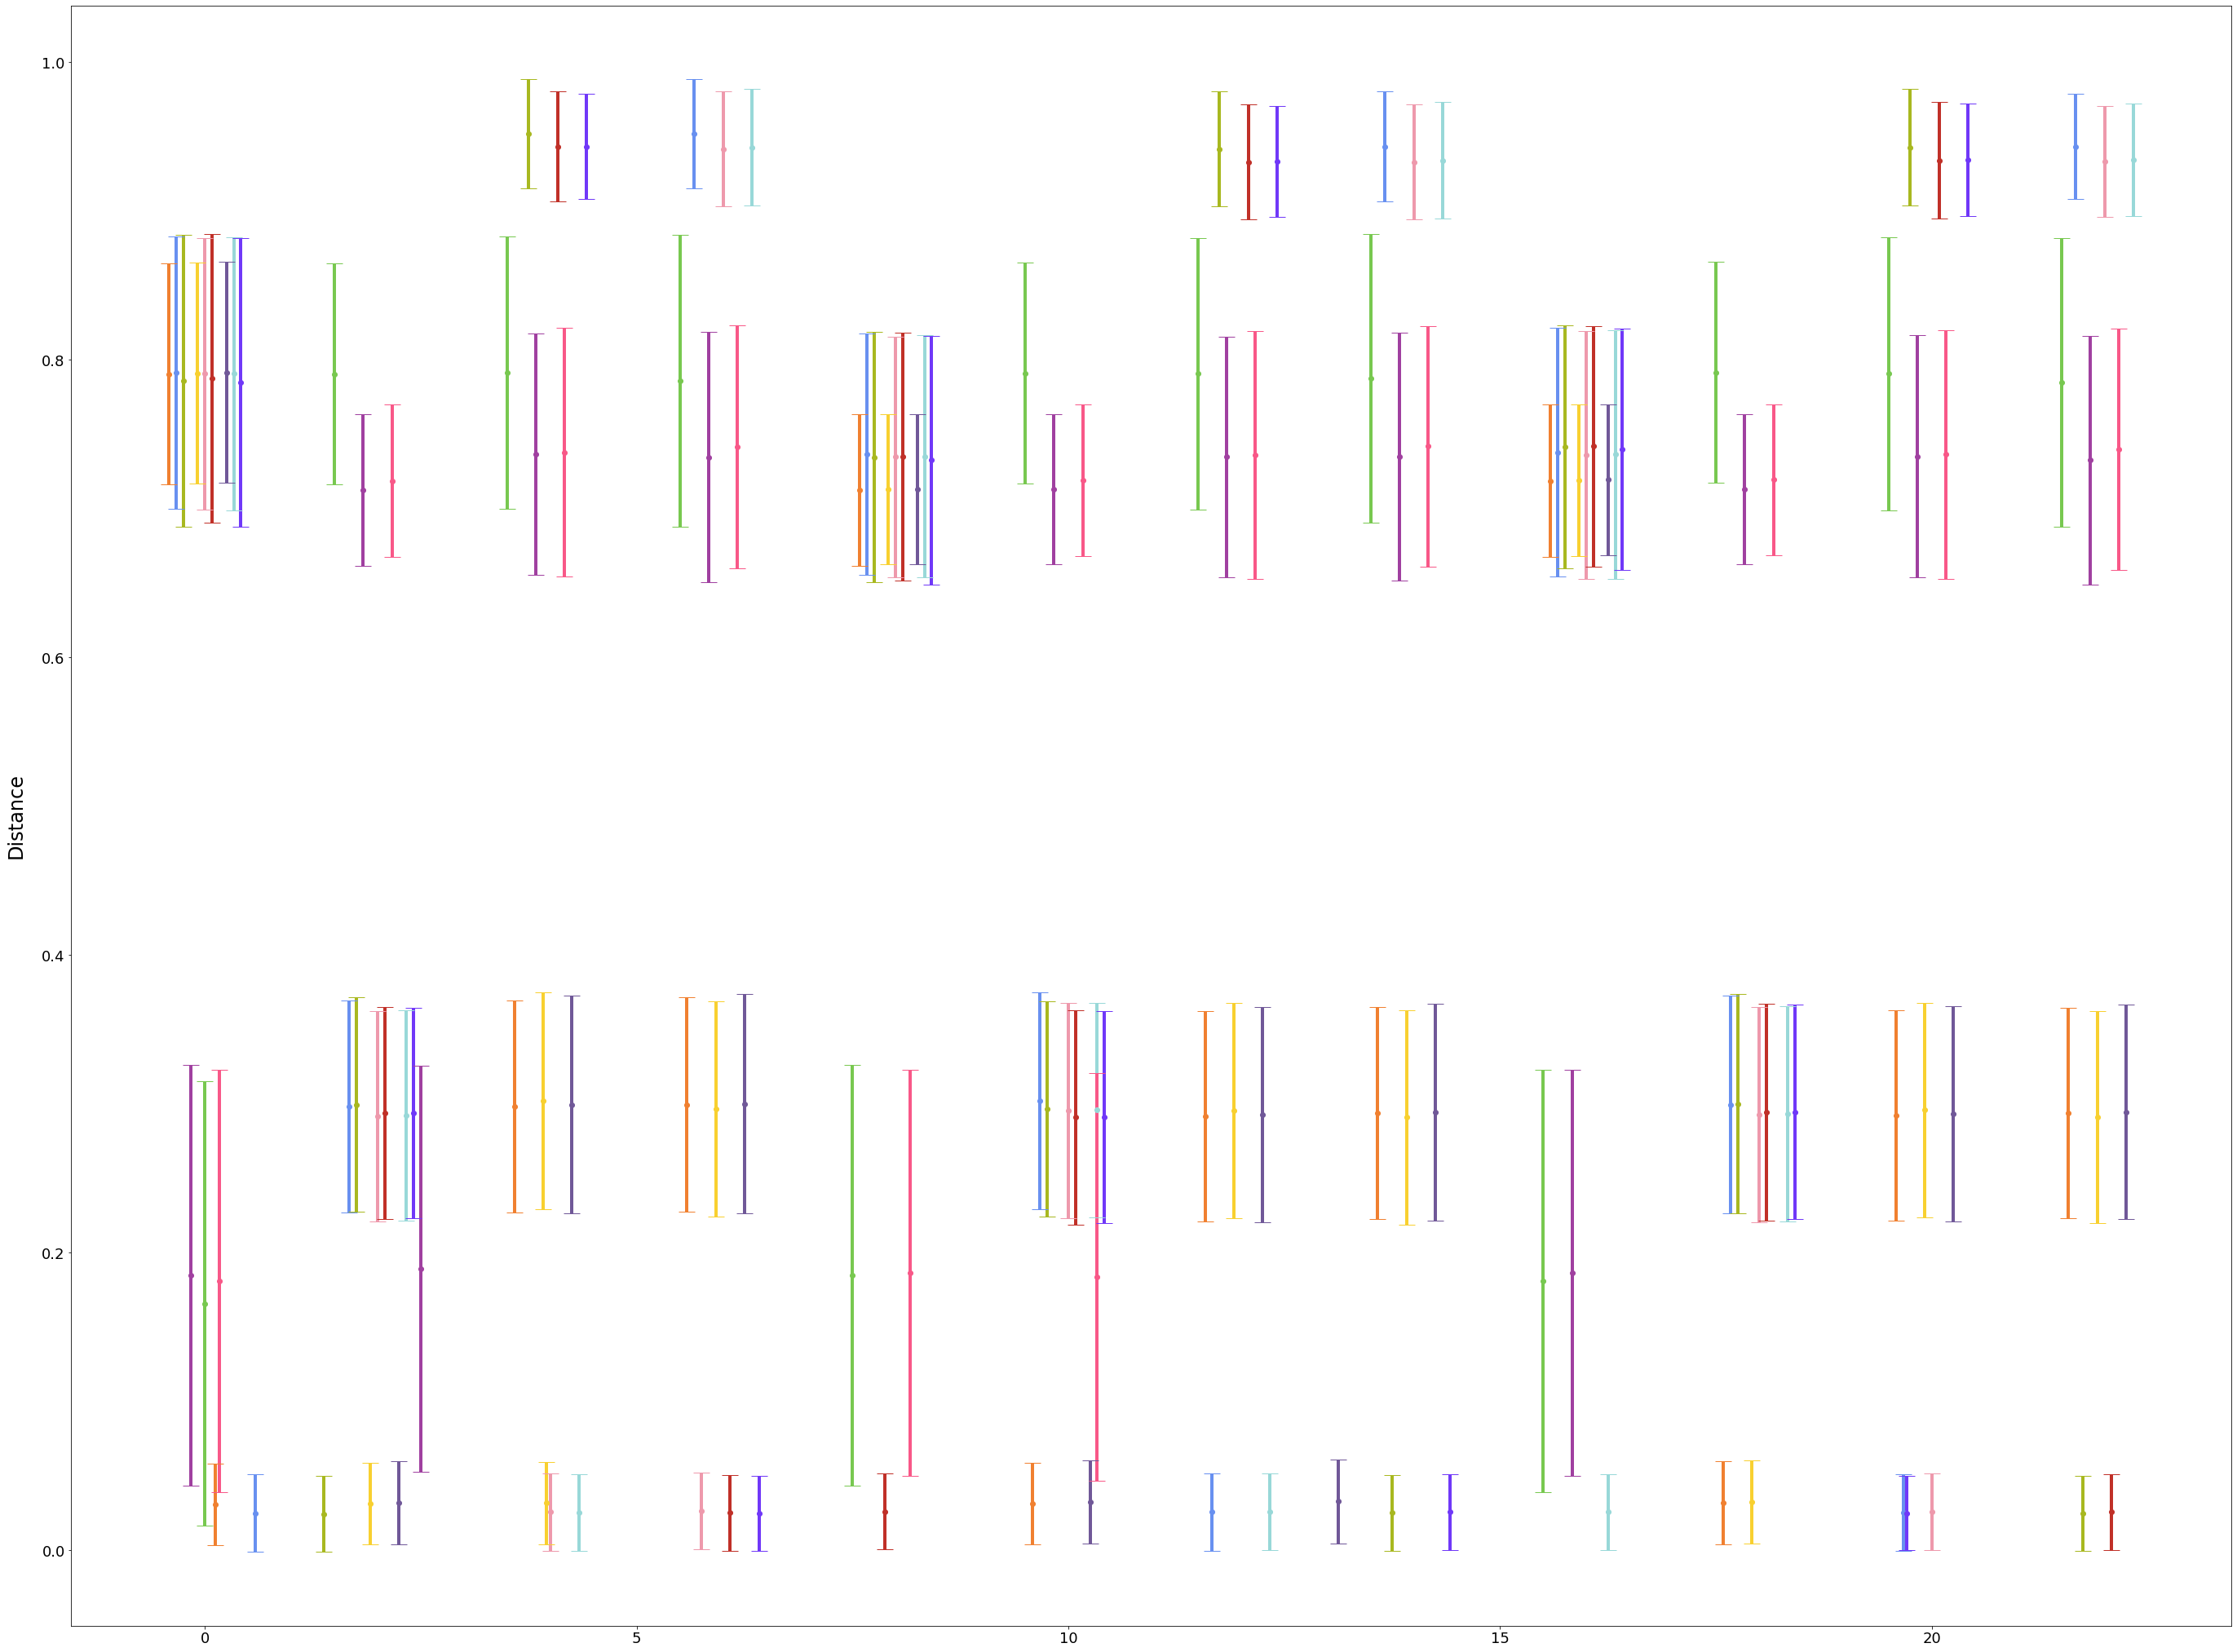

In [109]:
fig, ax = plt.subplots(figsize = (40,30))

plt.subplots_adjust(left=0.05,right=0.97,bottom=0.03,top=0.95)

keys = list(cluster_dict.keys())
metric_keys = ["Minkowski:p=0.5", "Euclidean", "Manhattan", "DotProduct", "Cosine", "1-SSIM", "1-LSA:k=20"]
clusters = list(range(len(keys)))

mean_between_distances_cos = between_distances_means_stds["Cosine"]
mean_within_distances_cos = within_distances_means_stds["Cosine"]

means_within = np.asarray(list(mean_within_distances_cos.values()))[:,0]
stds_within = np.asarray(list(mean_within_distances_cos.values()))[:,1]


print(clusters)
for c in clusters:
    x=c*2
    ax.errorbar((x-0.5) * c*1/12, means_within[c],stds_within[c],color= colors[c], lw=4, fmt='o', capsize=10)
    means_stds_between = mean_between_distances_cos[c]
    other_clusters = clusters.copy()
    other_clusters.remove(c)
    for i,j in enumerate(other_clusters):
        ax.errorbar((x-0.5) + j*1/12, means_stds_between[j][0],means_stds_between[j][1],color= colors[j], lw=4, fmt='o', capsize=10)
    
#ax.errorbar(list(within_cluster_distances.keys()), w_means, w_stds, lw=3, label = "Within",fmt='o', capsize=10)
#ax.legend(fontsize= 20)

ax.tick_params(axis='y',labelsize=18)
ax.tick_params(axis="x", labelsize = 18)
ax.set_ylabel("Distance", fontsize = 24,labelpad = 20)
#ax.set_xticks(range(0, len(list(between_cluster_distances.keys()))))
plt.savefig("test.pdf")

In [215]:
len(between_distances_means_stds["Cosine"].keys())

12

### Plot Heatmap of Distances between clusters grouped by Conditions 

In [224]:
def grouped_heatmap_plot(shape,
                         within_distances_mms_dict,
                         between_distances_mms_dict,
                         max_value,
                         row_conditions,
                         col_conditions,
                         row_conditions_occurance_in_data_interval,
                         col_conditions_occurance_in_data_interval,
                         clusters_row = None,
                         clusters_col = None,
                         title = "",
                         figsize = (20,20)):
    
    if clusters_row is None:
        clusters_row = list(range(len(within_distances_mms_dict.keys())))
    if clusters_col is None:
        clusters_col = list(range(len(within_distances_mms_dict.keys())))
    
    
    mean_distance_matrix = np.zeros((shape[0],shape[1]))

    #cluster_positions = list(range(n_clusters))
    
    for c,cluster in enumerate(clusters_row):
        for i,j in enumerate(clusters_col):
            if cluster == j:  
                mean_distance_matrix[c,i] = within_distances_mms_dict[cluster][1]
            else:
                mean_distance_matrix[c,i] = between_distances_mms_dict[cluster][j][1]


        #other_clusters = clusters.copy()
        #other_cluster_positions = cluster_positions.copy()
        #other_clusters.remove(cluster)
        #other_cluster_positions.remove(c)
        #for i,j in enumerate(other_clusters):
            #mean_distance_matrix[c,other_cluster_positions[i]] = between_distances_mms_dict[cluster][j][1]

            
    mean_distance_matrix = mean_distance_matrix/np.round(max_value)
    
    rows = len(row_conditions)
    cols = len(col_conditions)
    
    fig, ax = plt.subplots(ncols=cols, nrows=rows,figsize = figsize)

    cmap = plt.cm.magma
    heatmapkws = dict(square=False, cbar=False, cmap = cmap, vmin=0, vmax= 1,annot_kws={"fontsize":15}) 
    
    
    
    
    row_labels = row_conditions#["Small Amplitude", "Medium Amplitude", "Large Amplitude"]
    col_labels = col_conditions#["Small Amplitude", "Medium Amplitude", "Large Amplitude"]
    
    cluster_in_rows = sum([list(range(i,shape[0],row_conditions_occurance_in_data_interval)) for i in range(row_conditions_occurance_in_data_interval)],[])
    
    
    for row in range(rows):
        cluster_in_columns = sum([list(range(i,shape[1],col_conditions_occurance_in_data_interval)) for i in range(col_conditions_occurance_in_data_interval)],[])
        
        data_rows = cluster_in_rows[:int(shape[0]/rows)]
        for i in data_rows:
            cluster_in_rows.remove(i)
       
        for col in range(cols):
            data_cols = cluster_in_columns[:int(shape[1]/cols)]
            for i in data_cols:
                cluster_in_columns.remove(i)     
            
            yticklabels = col == 0
            xticklabels = (row == 0 or row == len(row_conditions) -1)
        
            sns.heatmap(mean_distance_matrix[np.ix_(data_rows,data_cols)],ax=ax[row,col],annot=True,fmt=".2f",**heatmapkws, yticklabels = yticklabels, xticklabels = xticklabels)
            
            if col == 0:
                ax[row,col].set_yticklabels(np.asarray(clusters_row)[data_rows])
                ax[row,col].set_ylabel(row_labels[row],fontsize = 24,labelpad = 20)
                ax[row,col].tick_params(axis='y',labelsize=18)

            if row == 0 or row == len(row_conditions) -1:
                ax[row,col].set_xticklabels(np.asarray(clusters_col)[data_cols])
                ax[row,col].set_xlabel(col_labels[col],fontsize = 24,labelpad = 20)
                if row == 0:
                    ax[row,col].xaxis.tick_top()
                    ax[row,col].xaxis.set_label_position('top')

                ax[row,col].tick_params(axis="x", labelsize = 18)
    
    

    norm = matplotlib.colors.Normalize(vmin= 0, vmax= 1)
    cax = fig.add_axes([0.93,0.1,0.03,0.8])

    sm = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cax)
    cax.tick_params(labelsize = 24)
    plt.subplots_adjust(wspace = 0.05, hspace = 0.05)

    fig.suptitle(title, fontsize=28)
    

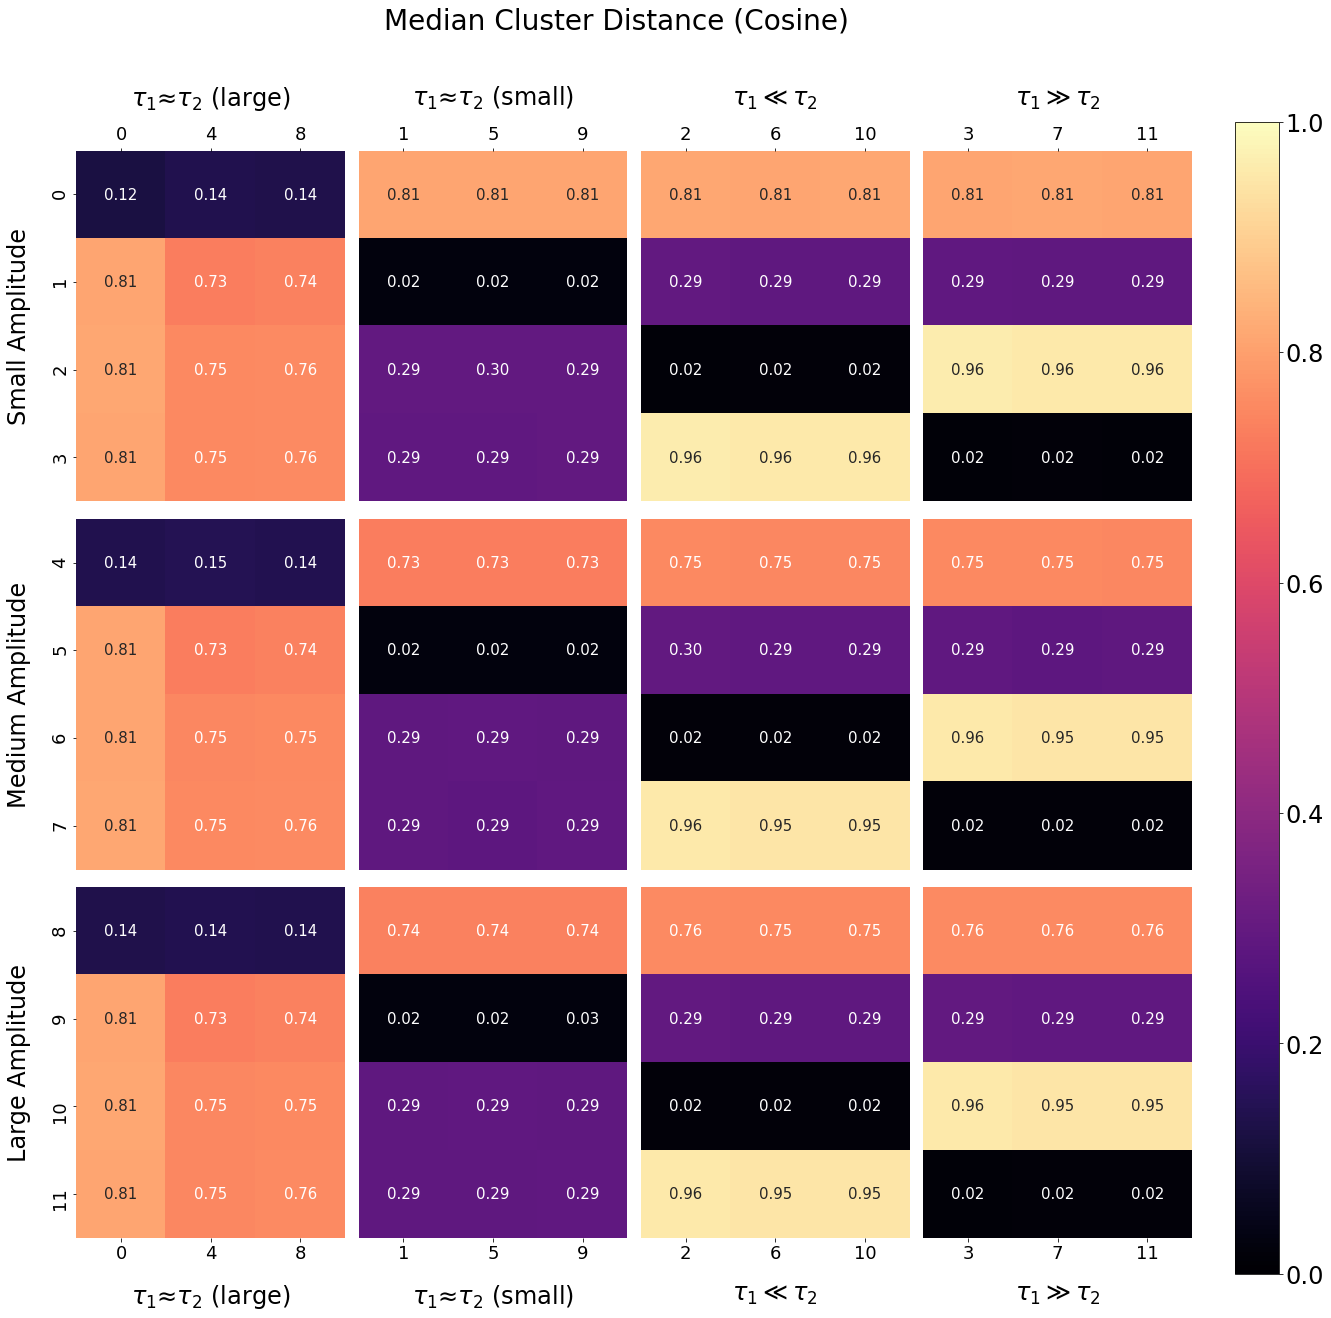

In [220]:
n_clusters = (12,12)
metric = "Cosine"
max_value = 1
#row_conditions = [r'$\tau_1 ≈ \tau_2$ (large)', r'$\tau_1 ≈ \tau_2$ (small)', r'$\tau_1 \ll \tau_2$', r'$\tau_1 \gg \tau_2$']
col_conditions = [r'$\tau_1 ≈ \tau_2$ (large)', r'$\tau_1 ≈ \tau_2$ (small)', r'$\tau_1 \ll \tau_2$', r'$\tau_1 \gg \tau_2$']
row_conditions = ["Small Amplitude", "Medium Amplitude", "Large Amplitude"]
#col_conditions = ["Small Amplitude", "Medium Amplitude", "Large Amplitude"]

row_conditions_occurance_in_data_interval = 1
col_conditions_occurance_in_data_interval = 4
title = "Median Cluster Distance (%s)" % metric


grouped_heatmap_plot(n_clusters,
                     within_distances_means_stds[metric],
                     between_distances_means_stds[metric],
                     max_value,
                     row_conditions,
                     col_conditions,
                     row_conditions_occurance_in_data_interval,
                     col_conditions_occurance_in_data_interval,
                     title = title,
                     figsize = (20,20))
    
#plt.savefig("heatmap_%s_amplitude_vs_time_constant" % metric.replace(".",""))

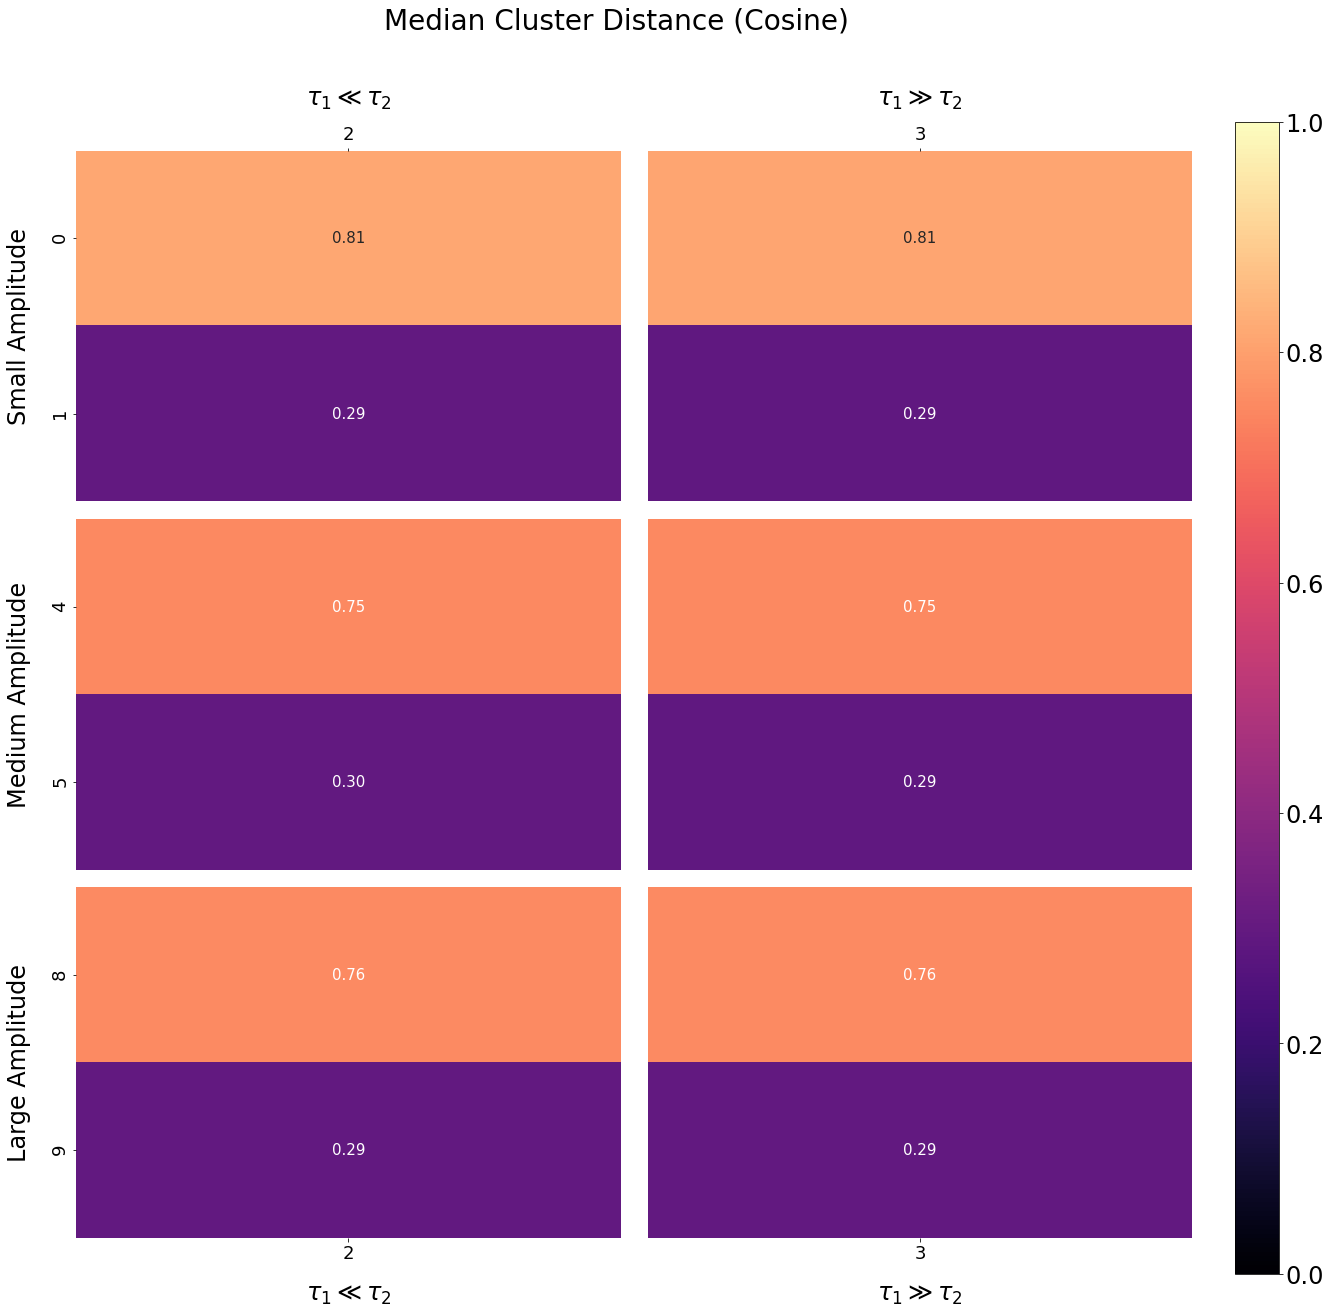

In [226]:
n_clusters = 6
metric = "Cosine"
max_value = 1
#row_conditions = [r'$\tau_1 \ll \tau_2$', r'$\tau_1 \gg \tau_2$']
col_conditions = [r'$\tau_1 \ll \tau_2$', r'$\tau_1 \gg \tau_2$']
row_conditions = ["Small Amplitude", "Medium Amplitude", "Large Amplitude"]
#col_conditions = ["Small Amplitude", "Medium Amplitude", "Large Amplitude"]

row_conditions_occurance_in_data_interval = 1
col_conditions_occurance_in_data_interval = 2
title = "Median Cluster Distance (%s)" % metric


grouped_heatmap_plot((6,2),
                     within_distances_means_stds[metric],
                     between_distances_means_stds[metric],
                     max_value,
                     row_conditions,
                     col_conditions,
                     row_conditions_occurance_in_data_interval,
                     col_conditions_occurance_in_data_interval,
                     clusters_row = [0,1,4,5,8,9],
                     clusters_col = [2,3],
                     title = title,
                     figsize = (20,20))
    
plt.savefig("heatmap_%s_amplitude_equal_vs_time_constant_skewed_clusters" % metric.replace(".",""))

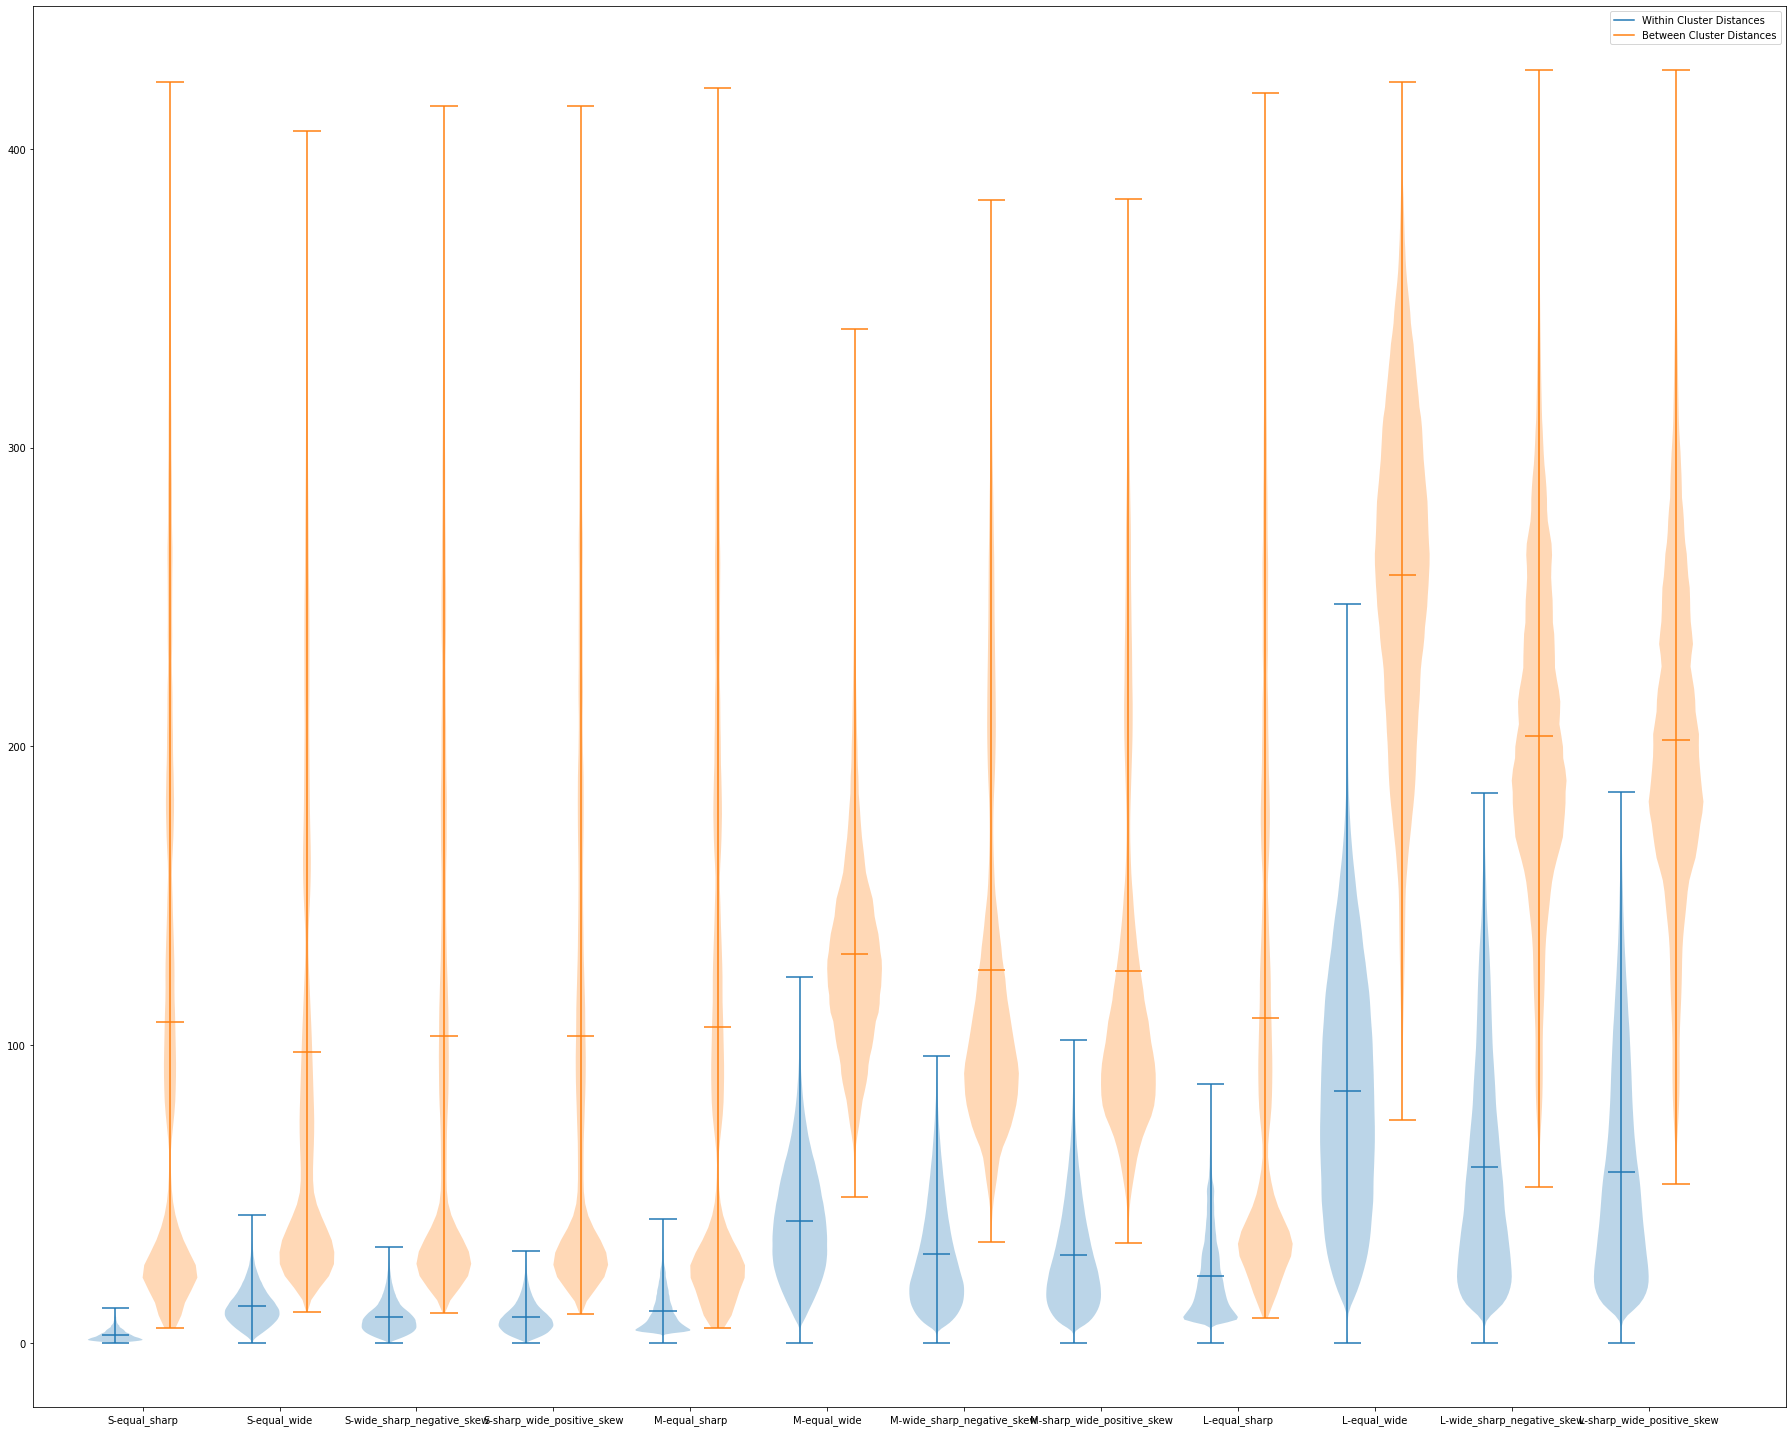

In [28]:

ticks = [key for key in between_cluster_distances]
wd = [within_cluster_distances[key].ravel() for key in within_cluster_distances.keys()]
bd = [between_cluster_distances[key].ravel() for key in between_cluster_distances.keys()]



plt.figure(figsize=(25,20))

bpl = plt.violinplot(wd, positions=np.array(range(len(wd)))*5-1, widths=2,showmeans = True, showextrema = True)
bpr = plt.violinplot(bd, positions=np.array(range(len(bd)))*5+1, widths=2,showmeans = True, showextrema = True)


# draw temporary red and blue lines and use them to create a legend
plt.plot([], color = "C0", label='Within Cluster Distances')
plt.plot([], color = "C1", label='Between Cluster Distances')
plt.legend()

plt.xticks(range(0, len(ticks) * 5, 5), ticks, rotation = 90)
plt.xlim(-4, len(ticks)*5)
plt.tight_layout()

## Test Performance with spectral clustering

In [60]:
validation_set = clear_validation_set
true_labels = clear_true_labels[clear_train_fold_indices[1]]
layout = clear_layout_label_mapping
save_file = "clear_clusters_k=10_reg=None_cosine.pdf"

In [160]:
sim_matrix = validation_set @ validation_set.T 
diag = sim_matrix.diagonal()
denom = diag.reshape((len(diag),1)) + diag
sim_matrix = 2 * sim_matrix / denom

In [54]:
dist_matrix, sorted_dist_matrix = calculate_dist_matrix(validation_set, "euclidean")

In [162]:
weigthed_dist_matrix = (1 - sim_matrix) * dist_matrix

In [33]:
A = np.zeros((len(validation_set),len(validation_set)))
rows = np.arange(0,len(validation_set)).reshape((len(validation_set),1))
rows = np.repeat(rows,20, axis = 1)
columns = np.argsort(sim_matrix)[:,-21:-1]
A[rows,columns] = dist_matrix[rows,columns]

In [56]:
dist_matrix = pairwise_distances(validation_set, validation_set, metric = "cosine")

In [61]:
labels_valid, eigvec_valid, eigval_valid = spectral_clustering(validation_set, "precomputed", "distance",range(1,50), k=10, precomputed_matrix=dist_matrix, mutual = False, weighting = False, normalize = True, reg_lambda = None, save_laplacian = False, save_eigenvalues_and_vectors = False)

Use precomputed matrix for constructing KNN-Graph
Build symmetric KNN-Graph based on Distance of data points!
Weighting: False
Calculate Normalized Laplacians
Calculate Eigenvalues and Vectors of Laplacian


In [62]:
valid_labels = {}
for i, labels in enumerate(labels_valid):
    valid_labels[i+1] = labels

In [83]:
len(valid_labels[12])

12600

In [63]:
functions_for_plotting.plot_clusters(validation_set, true_labels, valid_labels[12], 3,4, layout,figsize=(20,20),n_bursts = 100,y_lim = (0,16), save_file=save_file ,subplot_adjustments= [0.05,0.95,0.03,0.9,0.4, 0.15], plot_mean=False, title= "Validation Set Clusters" )
#functions_for_plotting.plot_clusters(ambig_validation_set, ambig_true_labels[ambig_train_fold_indices[1]],ambig_valid_labels[45], 10,5, ambig_layout_label_mapping,figsize=(40,30),n_bursts = 100,y_lim = (0,16),save_file="test.png" ,subplot_adjustments= [0.05,0.93,0.02,0.92,0.9, 0.2], plot_mean=False, title= "Validation Set Clusters ")

/Users/paule/Desktop/Burst_Clustering/functions_for_plotting.py:271: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(outer_grid[row_i:(row_i + 1), column_i])
/Users/paule/Desktop/Burst_Clustering/functions_for_plotting.py:277: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(outer_grid[row_start:row_end, corresponding_column])
/Users/paule/Desktop/Burst_Clustering/functions_for_plotting.py:27

# Graph Analysis

In [7]:
A = construct_knn_graph(dist_matrix,sorted_dist_matrix,k=len(ambig_data)-1, mutual = False, weighting = "distance")

In [8]:
np.mean(A)

115.34996749952657

In [ ]:
import igraph as ig
import cairocffi as cairo
g = ig.Graph.Famous("petersen")
ig.plot(g)

In [ ]:
color_dict = {}
for i in range(10):
    color_dict[i] = "C%d" % i

color_dict[10] = "black"
color_dict[11] = "white"

In [ ]:
g = ig.Graph.Adjacency((A > 0).tolist())

# Add edge weights and node labels.
g.es['weight'] = A[A.nonzero()]
#g.vs['color'] = [color_dict[i] for i in clear_true_labels]  # or a.index/a.columns

In [ ]:
layout = g.layout_lgl()

#ig.plot(g,layout = "layout_lgl")

In [ ]:
ig.plot(g, layout = layout)